## PHYS 211/334 Python Example Scripts
## Example 2 - Least Squares Error

- **PROGRAM**: This script reads in data (x, y, yerr) from a file and fits the points to a straight line using the least-squares technique.
- **INPUT**: Example2_Data2.tsv
- **CREATED**: 09-11-2014
- **AUTHOR**: David McCowan [modified from work by William Irvine (2012), Frank Merrit (2013) and Michael Fedderke (2013)]
- **EDITED**: 08-12-2016, converted from python script to ipython notebook.
- **EDITED**: 07-27-2017, minor tweaks, updated to Python3.
- **EDITED**: 09-12-2018, fixed Jupyter formatting issues.
- **REVISED**: 08-20-2020, updated to in-notebook exercises (Kevin Van De Bogart).
- **REVISED**: 9-26-2022, added glossary and information about array slicing.  Altered fitting code to return nan for $\chi^2$ when fit fails.
- **REVISED**: 9-5-2024, minor changes, introduced one-line code to print the contents of a file for troubleshooting.

# Part 1: Loading data from files

---

Often, you'll have data that's already entered into a computer in some form.  Let's look at how we can use `numpy` to load pre-formatted data into Python quickly.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
data_filename = 'Example2_Data.tsv'
    # This defines the name of our data file.

using_colab = False
    # Change to False if you are running Juptyer locally.

If you are working on your own computer, you need to make sure that the file you want to import is placed in the same directly as the notebook you are running.

If you are working with Google Colab, we need an extra step to get files to a place that Python can interact with them. For that we use the `files` package within `google.colab`.  

In [2]:
if using_colab:
  from google.colab import files
  uploaded = files.upload()
  data_filename = next(iter(uploaded.keys()))
  # This last line is a trick that will automatically pull the filename from what you uploaded.

Let's use Python to look at what's in our file.  We can do this quickly by comgining three commands:
  - `open` tells Python to access the file
  - `.read()` tells Python to read out all of the text in the file
  - `print` dumps the contents on the screen

In [3]:
print(open(data_filename).read())

x	y	yerr
0	4.2	1.2
1	6.1	0.8
2	8	0.9
3	10	0.9
4	13.5	0.4
5	15.3	0.6
6	20.5	0.7
7	25.3	0.8
8	30.3	0.8
9	32.1	1
10	40.1	1.1



Unfortunately, just reading the text from the file doesn't give us anything we can really work with, everything is considered text.

To extract data, we'll use the numpy command `np.loadtxt()`.
- The first argument (`data_filename`) is a string containing the file name.
- The default is for `loadtxt()` to read in one row at a time and treat each as an individual numpy array (`unpack=False`). It will look for tabs or spaces to separate elements in the list.
  - Our data, however, is arranged in columns, not rows. We therefore need to transpose the arrays by using `upack=True`. (Almost all the data we deal with in this course will be arranged this way.)
- Sometimes there is information at the top of the file we want to ignore. We can use `skiprows = n` to skip `n` rows.
- Sometimes there are columns of information in the file we don't want to use. We may use `usecols = [0,2,4]` for example, to pull out only the first, third and fifth columns. (Python always counts zero as the first element of a list.)
  - Since we're using three columns, we assign them to three variables: `x`, `y`, and `dy`, respectively. 

In [4]:
x, y, dy = np.loadtxt(data_filename, unpack=True, skiprows=1, usecols=[0,1,2])

We can use a quick `print` command to verify that we've loaded the data we wanted to.

In [5]:
print(x)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


Let's make a basic  plot to verify we've got everything we expect here.  The default plot settings aren't great, but they'll do the trick for making sure nothing strange has happened.

<ErrorbarContainer object of 3 artists>

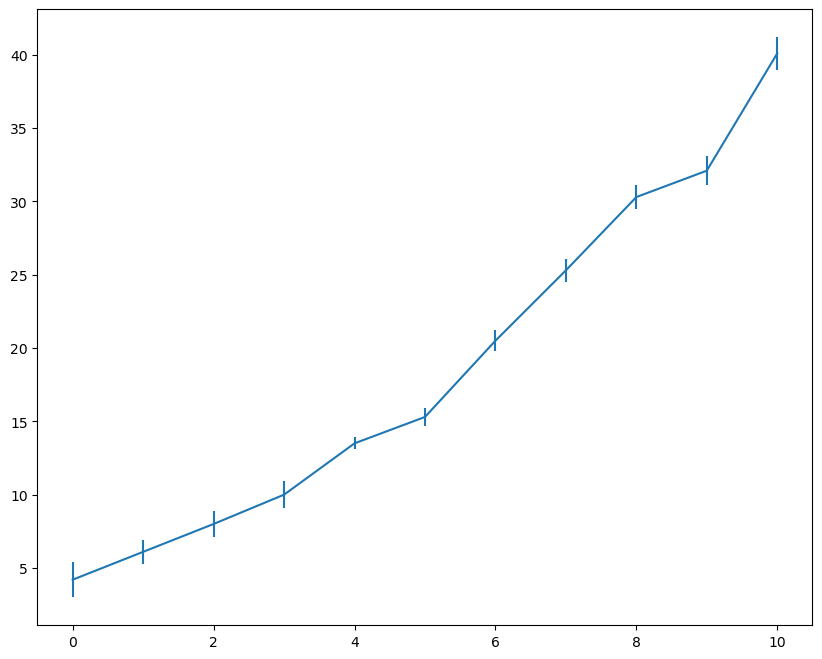

In [6]:
%matplotlib inline
fig, ax = plt.subplots(figsize = (10,8))
ax.errorbar(x,y,dy)

Let's say we *think* the data are linear. Let's define a linear function that we can plot alongside our data points.

In this case we're going to define our fit function as `fitfunc(p, xvar)`.
- We want our function to have the form of `f(x) = a + bx`.
- For reasons we'll see later, it helps to put all the fit parameters into a single array. 
  - In our notation, the array is `p` with `p[0] = a`, and `p[1] = b`.

In [7]:
def linear(p, xvar):
    return p[0] + p[1]*xvar

## Aside: Notes on manipulating numpy arrays
----
Numpy has some very powerful tools for selecting just parts of arrays we want to use.  If we put just a number in square brackets, then we get the nth number in the array back (note that Python starts counting at 0).  This can even work backwards, a negative number counts from the end of an array.  

For some more information on manipulating arrays, see https://physlab-wiki.com/phylabs/lab_courses/supplemental-material/programming/numpy_cheatsheet/start#indexing

In [8]:
print(x)
print(x[0])
print(x[2])
print(x[-2])

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
0.0
2.0
9.0


----
## Back to fitting! 

We can use this function right now to see if it is a decent fit for our data.  We'll do this by guessing some fit parameters and calculating the y values that would be associated with each datapoint.

To start out, we're plotting the line $f(x) = 3x$.
  - This is reflected in the guess parameters of 0 (no offset) and 3 (slope of 3).
  - We use our function to generate y values associated with each datapoint with `linear(guess,x)`.

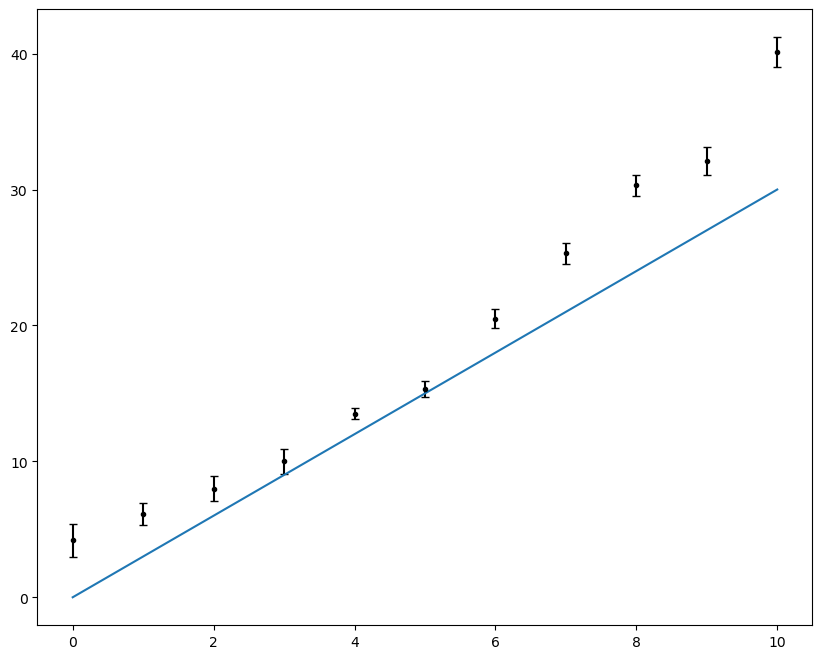

In [9]:
fig, ax = plt.subplots(figsize = (10,8))
ax.errorbar(x,y,dy,fmt='k.',capsize = 3)
guess = [0,3]
calculated_y = linear(guess,x)
ax.plot(x,calculated_y)

---
# Task 1
---
Copy the code above and adjust the parameters to get a line that's a better fit to our data.  Don't worry about being formal about it, that's the next part of this tutorial.
 - Create a different variable for your parameters named `my_guess`.
 - Make sure that you're using this variable when you're calculating y values.

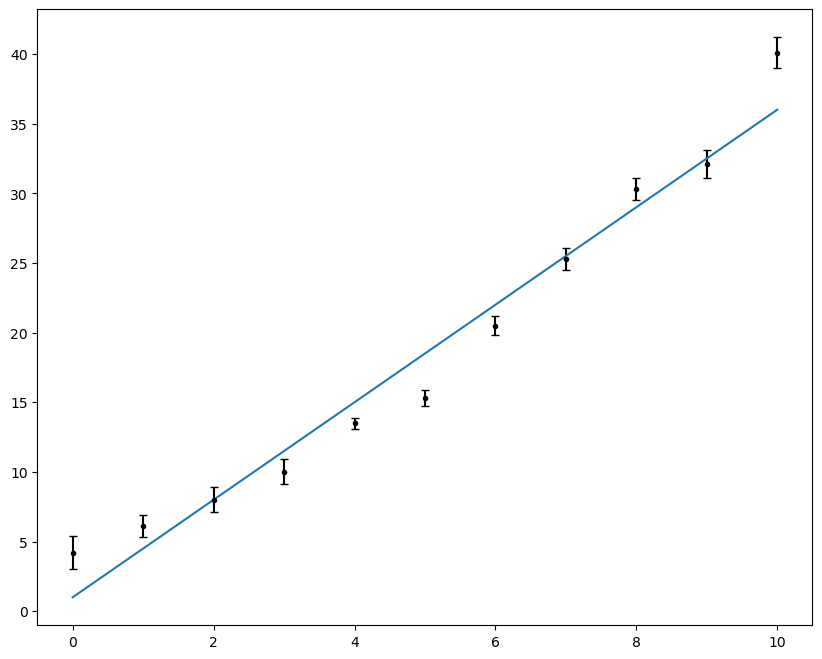

In [10]:
fig, ax = plt.subplots(figsize = (10,8))
ax.errorbar(x,y,dy,fmt='k.',capsize = 3)
my_guess = [1,3.5]
calculated_y = linear(my_guess,x)
ax.plot(x,calculated_y)

---
# Part 2: Residuals

As you might've noticed, this isn't a very objective way to determine if a line is a good fit for the underlying data.  To remedy this, we'll create a second function that calculates residuals.
- The residual for a point `x` is the difference between the fit function evaluated at that point and the actual data `f(x) - y`.
- We weight each residual by dividing by the corresponding uncertainty `dy`. 
  - Points with small error bars "count more" in the fit than points with large error bars.
- The result $(f(x) - y) / dy$ is a general formula for finding residuals, we can use whatever function we want as an argument here.
  - If you ever give this function a value of 0 for `dy`, you will get a divide-by-zero error and your residual will be infinite (`inf`).
- This would need to be modified on a case-by-case basis to include residues due to uncertainties in the `x` direction.

Let's define a weighted residual as `residual(p, func, xvar, yvar, err)`


In [11]:
def residual(p,func, xvar, yvar, err):
    return (func(p, xvar) - yvar)/err
    #Yes, this is a function of a function.  You can do that!

We can test this function quickly be printing out the results.  Note that since we're using arrays of data for `x`,`y`, and `dy`, the result is an array of residuals calculated point-by-point.  
If you get an error that starts with:

`ValueError: operands could not be broadcast together with shapes ...`

then you've got a problem with your arrays having different lengths.

In [12]:
print(residual(guess,linear,x,y,dy))

[-3.5        -3.875      -2.22222222 -1.11111111 -3.75       -0.5
 -3.57142857 -5.375      -7.875      -5.1        -9.18181818]


If we were to just sum up the residuals, residuals from points far above the line would cancel out with ones far below the line.  To avert this problem, we're going to square each of the residual values when we're trying to figure out if our fit is good or not.

The sum of the squares of all of the residuals is the $\chi^2$ (chi squared) statistic.  The larger $\chi^2$ is, the bigger the average difference between our function and our data.


In [13]:
chisq = sum(residual(guess,linear,x,y,dy)**2)
print(chisq)

261.72810167095616


As a next step, let's plot our residuals along with our data, sort of like what we did in the first exercise.


chisq value = 261.72810167095616


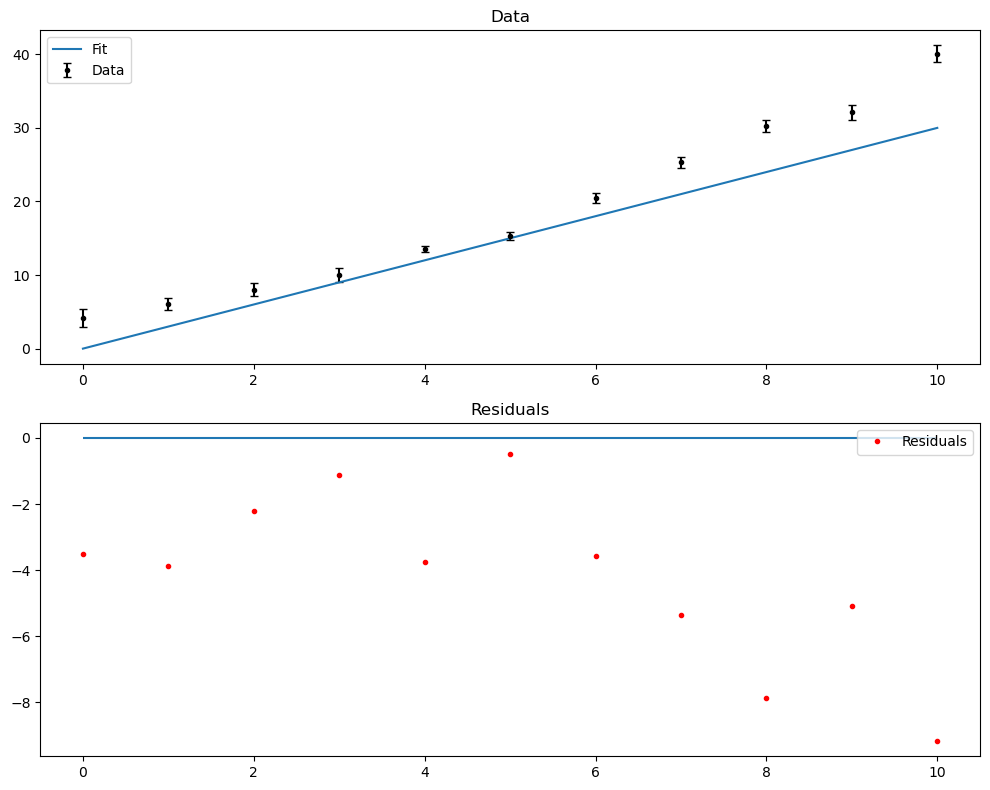

In [14]:
fig = plt.figure(figsize = (10,8))
ax =fig.add_subplot(2,1,1)
ay =fig.add_subplot(2,1,2)
#fig,(ax,ay) = plt.subplots(nrows=2, ncols=1)
#the above is an equivalent way of doing the same thing

ax.errorbar(x,y,dy,fmt='k.',label='Data',capsize=3)
    # A basic scatter plot of some data in red
ax.plot(x,linear(guess,x),label='Fit')
    # A plot of just the magnitudes of the errors
    # Note that you don't have to calculate the y values ahead of time, you can just use linear when calling the plot function.
ax.set_title("Data")
ax.legend()

ay.plot(x,residual(guess,linear, x, y, dy),'r.',label='Residuals')
ay.hlines(0,0,10)
ay.set_title("Residuals")
ay.legend()
fig.tight_layout()

chisq = sum(residual(guess,linear,x,y,dy)**2)
print("chisq value =",chisq)

If our function was a good fit for the data, then the residual values would be clustered around zero.  Right now, we can see that they're almost all negative, indicating our function is undershooting our data.

---
# Task 2
---
In the cell below, modify the previous graph by including the function that uses the parameters you came up with (`my_guess`) back in part 1.
- You can start by copying the code above and adding in another `ax.plot` function for your line.
- You should also add an `ay.plot` function to show the residuals for your fit parameters.
- Finally, you should calculate the $\chi^2$ statistic for your parameters. 

chisq value = 77.74335705149826


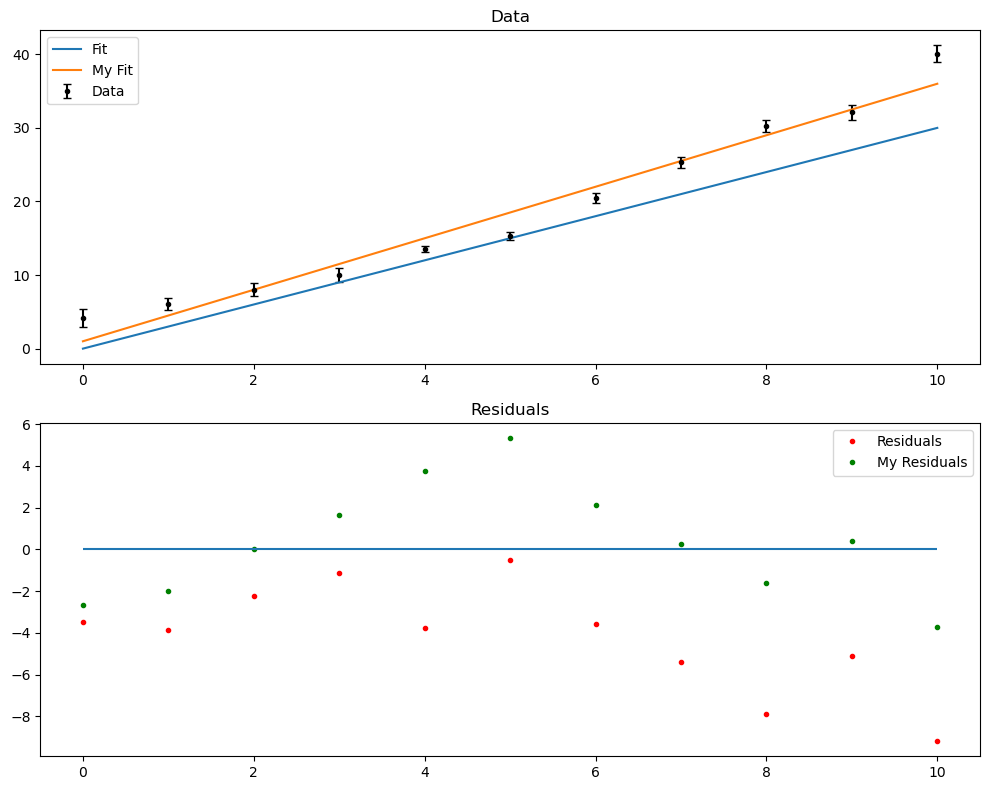

In [15]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(10, 8))

ax0.errorbar(x,y,dy,fmt='k.',label='Data',capsize=3)
ax0.plot(x,linear(guess,x),label='Fit')
ax0.plot(x, linear(my_guess, x), label='My Fit')
    # A plot of just the magnitudes of the errors
    # Note that you don't have to calculate the y values ahead of time, you can just use linear when calling the plot function.
ax0.set_title("Data")
ax0.legend()

ax1.plot(x,residual(guess,linear, x, y, dy),'r.',label='Residuals')
ax1.plot(x, residual(my_guess, linear, x, y, dy), 'g.', label='My Residuals')
ax1.hlines(0,0,10)
ax1.set_title("Residuals")
ax1.legend()
fig.tight_layout()

chisq = sum(residual(my_guess,linear,x,y,dy)**2)
print("chisq value =",chisq)

---
# Part 3: Formatting text

Now for some sidetracking: formatting text.  As you might've noticed, Python will gladly show you as many digits as it can when you want to print out values.  We really don't want to see all 14 digits when we print out $\chi^2$ values.  In order to round values to be more readable, we will use the `format` command.

In [16]:
animal = "frogs"
dumb_animal = "blobfish"
number = 90.01
print("I think that {} are {:.0%} cooler than {}.".format(animal,number,dumb_animal))

I think that frogs are 9001% cooler than blobfish.


In the instance above, we used a pair of curly brackets `{}` to indicate that we're going to put a variable in that location using the `.format` command.

If we include a colon in the curly brackets, we can specify formatting information.

The snippet `{:.0%}` tells Python that we want to display the number as a percentage (`%`) with no decimals (`.0`).

Let's do the same sort of thing with our $\chi^2$ value.

In [17]:
chisq = sum(residual(guess,linear,x,y,dy)**2)
print("chisq value = {:0.2f}".format(chisq))

chisq value = 261.73


For another relevant example let's format text to show a variable alongside its uncertainty, rounding the calculated values to make it readible.

In [18]:
variable_1, dvariable_1 = 10, 0.412

print('$a = {:.2f} \\pm {:.2f}$'.format(variable_1,dvariable_1))

from IPython.display import display, Latex 
    #Python doesn't know how to render math with the print command, but we can make it do so with display(Latex())
display(Latex('$a = {:.2f} \\pm {:.2f}$'.format(variable_1,dvariable_1)))

$a = 10.00 \pm 0.41$


<IPython.core.display.Latex object>

We have to use a double slash `\\` here to indicate to Python that yes, we do really want a backslash there.  Otherwise Python tries to interpret `\p` as an [escape sequence](https://docs.python.org/3/reference/lexical_analysis.html#escape-sequences) which will cause a warning.

Here we used `{:.2f}` to indicate that we want two decimal places `.2` and that we want the number to be _converted_ to fixed-point format `f`.

There are lots of possible formatting options. For way, way too much information, see the [format specification mini-language](https://docs.python.org/3.4/library/string.html#formatspec).

The LaTeX option is not required, but we wanted to show how easy it is to add that functionality.

We could get away without the last part for now, but look what happens if we try to run the code with an integer variable below:

In [19]:
a = 2.28
aerr = 1

display(Latex('$a = {:.2} \\pm {:.2}$ \n'.format(a,aerr)))

ValueError: Precision not allowed in integer format specifier

---
# Task 3
--- 
Copy the cell above and fix it to make it display properly.

In [20]:
a = 2.28
aerr = 1

display(Latex('$a = {:.2f} \\pm {:.2f}$ \n'.format(a,aerr)))

<IPython.core.display.Latex object>

----
# Part 4: Curve Fitting

We now know how to plot data, and we can calcluate a $\chi^2$ goodness of fit parameter that gives us an objective measure of how well a function fits a set of data.  We could just stop here and manually try parameter values until we get things "good enough," but there's a better way!


We're now going to use scipy function `optimize.least_squares()` to find the function that best fits our data by minimizing $\chi^2$ automatically.

This function takes a `residual` function, an initial `guess` for parameters, and all of the variables needed to calculate the residual as a set of arguments `args`.  
It then systematically varies the parameters and calculates a $\chi^2$ value from the new function until there are minimal improvements.

In [21]:
optimize.least_squares(residual, guess, args=(linear,x, y, dy))

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-3.446e+00 -3.097e+00 -9.125e-01  8.171e-01  1.980e+00
                4.248e+00  1.293e+00 -4.225e-01 -2.227e+00 -2.463e-02
               -4.062e+00]
           x: [ 6.537e-02  3.557e+00]
        cost: 34.11949365418113
         jac: [[ 8.333e-01  0.000e+00]
               [ 1.250e+00  1.250e+00]
               ...
               [ 1.000e+00  9.000e+00]
               [ 9.091e-01  9.091e+00]]
        grad: [ 2.428e-07  9.133e-09]
  optimality: 2.428125733701118e-07
 active_mask: [ 0.000e+00  0.000e+00]
        nfev: 3
        njev: 3

Well, it certainly did something!  We could spend all quarter going into the details of what this function does and how it works, but that's not the point.  What we want to do is create something re-usable that extracts the important parts of this data in a way we can use to annotate plots.

To make this as re-usable as possible, we're going to create our own function called `data_fit()`

The inputs to this function will be the same as the `least_squares` function, and its outputs will be the specific variables we need.  For us, the four critical ones are:
- an array of best fit parameters `fit['x']` (saved to `pf`);
- the jacobian matrix at the solution `fit['jac']`;
  - This is used to find a covariance matrix by taking the inverse of the jacobian dotted with its transpose.
- a message giving more details of the convergence (or not) of the fit (saved as `message`); and
- a number that describes the success (or not) of the fit (saved as `status`). 
  - (Values of 2 or 4 are successful fits. All others represent attempts that did not converge.)

After the fit, we will calculate and display a number of useful values.
- The chi-squared is calculated from the final fit parameters and our residual function.
- The number of "degrees of freedom," ($N$) which is the number of data points minus the the number of fit parameters.
- The reduced chi-square value, which is just $\chi^2 / N$.
  - If our uncertanties are normally distributed and we've accounted for them properly, this should be around 1.
- The uncertainties in the fit parameters as the square-root of the diagonal elements of the covariance matrix
  - The variance (uncertainty squared) of fit parameter `i` is `cov[i,i]`.

---
**This is more complex than anything else you've worked with thus far, and you aren't expected to need to modify or understand in detail how it works. This code is a tool that you will use throughout the quarter in order to do physics.**

In [22]:
# The code below defines our data fitting function.
# Inputs are:
# initial guess for parameters p0
# the function we're fitting to
# the x,y, and dy variables
# tmi can be set to 1 or 2 if more intermediate data is needed

def data_fit(p0,func,xvar, yvar, err,tmi=0):
    try:
        fit = optimize.least_squares(residual, p0, args=(func,xvar, yvar, err),verbose=tmi)
    except Exception as error:
        print("Something has gone wrong:",error)
        return p0,np.zeros_like(p0),np.nan,np.nan
    pf = fit['x']

    print()

    try:
        cov = np.linalg.inv(fit['jac'].T.dot(fit['jac']))          
        # This computes a covariance matrix by finding the inverse of the Jacobian times its transpose
        # We need this to find the uncertainty in our fit parameters
    except:
        # If the fit failed, print the reason
        print('Fit did not converge')
        print('Result is likely a local minimum')
        print('Try changing initial values')
        print('Status code:', fit['status'])
        print(fit['message'])
        return pf,np.zeros_like(pf),np.nan,np.nan
            #You'll be able to plot with this, but it will not be a good fit.

    chisq = sum(residual(pf,func,xvar, yvar, err) **2)
    dof = len(xvar) - len(pf)
    red_chisq = chisq/dof
    pferr = np.sqrt(np.diagonal(cov)) # finds the uncertainty in fit parameters by squaring diagonal elements of the covariance matrix
    print('Converged with chi-squared {:.2f}'.format(chisq))
    print('Number of degrees of freedom, dof = {:.2f}'.format(dof))
    print('Reduced chi-squared {:.2f}'.format(red_chisq))
    print()
    Columns = ["Parameter #","Initial guess values:", "Best fit values:", "Uncertainties in the best fit values:"]
    print('{:<11}'.format(Columns[0]),'|','{:<24}'.format(Columns[1]),"|",'{:<24}'.format(Columns[2]),"|",'{:<24}'.format(Columns[3]))
    for num in range(len(pf)):
        print('{:<11}'.format(num),'|','{:<24.3e}'.format(p0[num]),'|','{:<24.3e}'.format(pf[num]),'|','{:<24.3e}'.format(pferr[num]))
    return pf, pferr, chisq,dof

Running the cell only defines how to do a fit.  To actually do something, you'll need to call the `data_fit()` function.

In [23]:
print("Linear Fit")
pf, pferr, chisq, dof = data_fit(guess,linear, x, y, dy)

Linear Fit

Converged with chi-squared 68.24
Number of degrees of freedom, dof = 9.00
Reduced chi-squared 7.58

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 0.000e+00                | 6.537e-02                | 4.855e-01               
1           | 3.000e+00                | 3.557e+00                | 9.023e-02               


---
# Task 4
---
Use the `data_fit` function with your best fit parameters `my_guess`.  
- Save the results as a different set of variables
  - e.g. `my_pf`, `my_pferr`, etc.

The results should (nearly) the same as the cell above.  This is good, we'd hope that we'd come up with the same optimal solution regardless of starting point.

In [24]:
print("Linear Fit")
my_pf, my_pferr, my_chisq, my_dof = data_fit(my_guess,linear, x, y, dy)

Linear Fit

Converged with chi-squared 68.24
Number of degrees of freedom, dof = 9.00
Reduced chi-squared 7.58

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 1.000e+00                | 6.537e-02                | 4.855e-01               
1           | 3.500e+00                | 3.557e+00                | 9.023e-02               


---

# Part 5

Now, let's plot the data and the fit at the same time to see how good the fit turned out. Note that we want our fit function to be shown as a "continuous" function so we much plot it over many very closely spaced points.
- We use `X = np.linspace(...)` to produce an array of points stretching over the same range as the data variable `x`.

In addition, we'll add some annotations to the plot. This text will print data about the fit directly onto the figure. We introduce a few new features here:
- First, we want a lot of text, so we're going to write it one line at a time and then join it together, the `+=` function will append new text onto whatever we've already got.
- We again use LaTex formatting here with the dollar signs (`$`) around anything we want to to appear in "math" format
- The newline character (`\n`) is equal to the return key; it means "start a new line".  This is a relic of the age of typewriters & paper terminals where it would physically move to a new line of the page.

- We place the text on the plot with `text()`. In this function, we use the `transform = ax.transAxes` argument, so our first two numbers (0.05, 0.90) represent position *percents* in x and y. I.e., this will place the text at 5% over from origin and 90% up.

Finally, we adjust the plot axes so that the data points don't overlap with the plot edges. Unlike `axis()` from Example 1 -- which required you to specify both the x and y limits -- we will use `set_xlim()` to just set the x-axis limits.

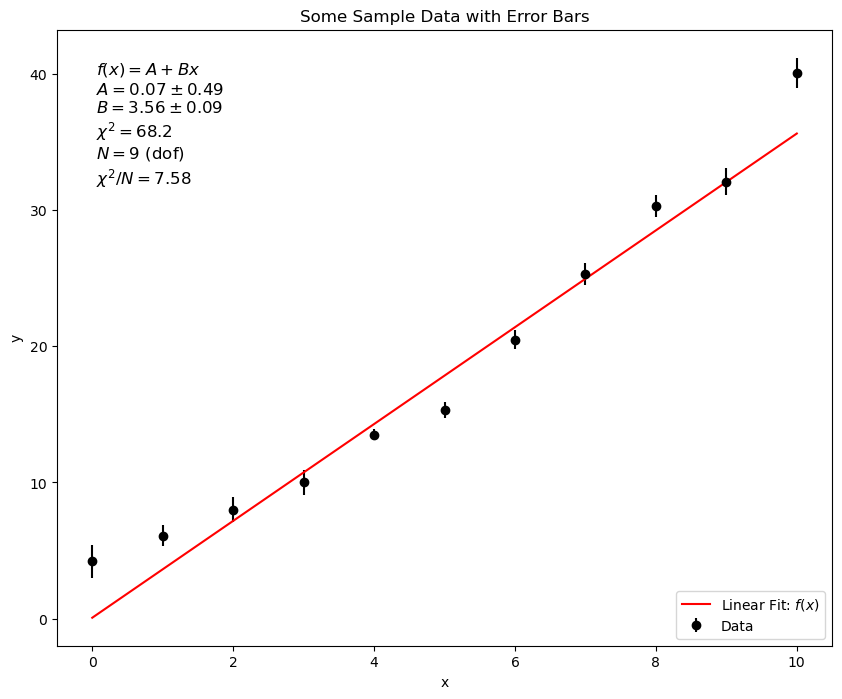

In [25]:
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(1,1,1)
ax.errorbar(x, y, dy, fmt='ko', label = 'Data')
X = np.linspace(x.min(), x.max(), 500)
ax.plot(X, linear(pf, X), 'r-', label = 'Linear Fit: $f(x)$')



ax.set_title('Some Sample Data with Error Bars')
ax.set_xlabel('x')
ax.set_ylabel('y')

# Here is the text we want to include...
textfit = '$f(x) = A + Bx$ \n' 
textfit += '$A = {:.2f} \\pm {:.2f}$ \n'.format(pf[0],pferr[0]) 
textfit +='$B = {:.2f} \\pm {:.2f}$ \n'.format(pf[1],pferr[1]) 
textfit += '$\\chi^2= {:.1f}$ \n'.format(chisq) 
textfit += '$N = {}$ (dof) \n'.format(dof) 
textfit += '$\\chi^2/N = {:.2f}$'.format(chisq/dof) 

#... and below is where we actually place it on the plot
ax.text(0.05, 0.95, textfit, transform=ax.transAxes , fontsize=12,verticalalignment='top')

ax.set_xlim([x.min()-0.5, x.max()+0.5])
  # x.min() is equal to the smallest x value in the entire array, x.max() is equal to the largest
  # Together this ensures that the axes always scale to be just slightly wider than the data.
ax.legend(loc='lower right')
#plt.savefig('Example2_Figure1.png',dpi=300)
plt.show()

if using_colab:
  files.download('Example2_Figure1.png') 

Hmm, it looks like this isn't a great fit.  Let's check our the residuals to see where things are going wrong.

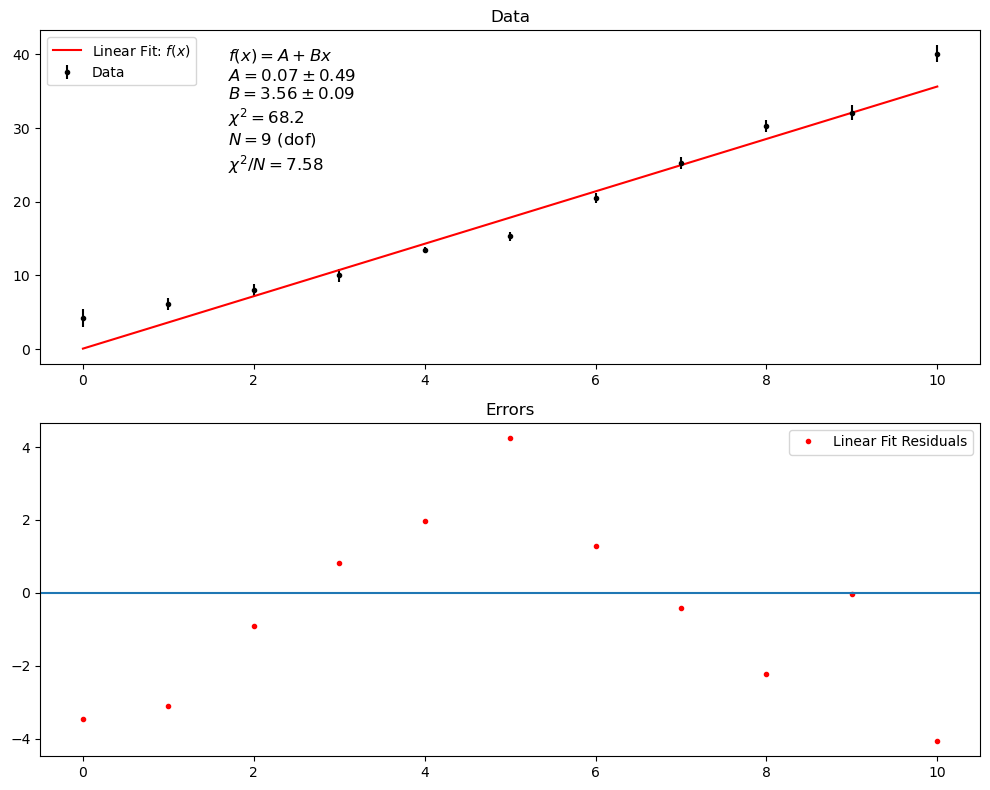

In [26]:
fig = plt.figure(figsize = (10,8))
ax =fig.add_subplot(2,1,1)
ay =fig.add_subplot(2,1,2)
#fig,(ax,ay) = plt.subplots(nrows=2, ncols=1)
#the above is an equivalent way of doing the same thing

ax.errorbar(x, y, dy, fmt='k.', label = 'Data')
    # A basic scatter plot of some data in red
X = np.linspace(x.min(), x.max(), 500)
ax.plot(X, linear(pf, X), 'r-', label = 'Linear Fit: $f(x)$')

# Here is the text we want to include...
textfit = '$f(x) = A + Bx$ \n' 
textfit += '$A = {:.2f} \\pm {:.2f}$ \n'.format(pf[0],pferr[0]) 
textfit +='$B = {:.2f} \\pm {:.2f}$ \n'.format(pf[1],pferr[1]) 
textfit += '$\\chi^2= {:.1f}$ \n'.format(chisq) 
textfit += '$N = {}$ (dof) \n'.format(dof) 
textfit += '$\\chi^2/N = {:.2f}$'.format(chisq/dof) 

#... and below is where we actually place it on the plot
ax.text(0.2, 0.95, textfit, transform=ax.transAxes , fontsize=12,verticalalignment='top')



ay.plot(x,residual(pf,linear, x, y, dy),'r.',label='Linear Fit Residuals')
    # A plot of just the magnitudes of the errors
ax.legend()
ay.legend()
ay.axhline(0)
ax.set_title("Data")
ay.set_title("Errors")
fig.tight_layout()

It looks like our function is undershooting on both sides and overshooting in the middle.  That's a good sign that a quadratic term could help!

---
# Task 5
--- 

Fit a quadratic function $g(x) = a + bx + cx^2$ to your data.
- Start by defining a quadratic function(`quadratic`) in the same way your linear function was defined back in part 1.
  - Notice that you'll use three parameters for this, so you'll have to have a different guess than the linear function.
- Use the next cell to test your function.  If you don't get a parabola, check your function again.
- Use the `data_fit` function to find the parameters that give the best fit of your new function to your data.
- Plot your data, your optimal fit, and the residuals together as a stacked pair of plots.  Use the code just above this as a starting point.

In [27]:
def quadratic(p, xvar):
    return p[0] + p[1] * xvar + p[2] * (xvar ** 2)

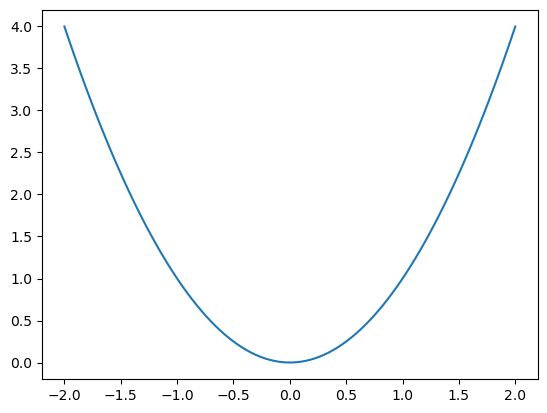

In [28]:
fig, ax = plt.subplots()
test_x = np.linspace(-2,2,100)

quad_guess = [0,0,1]

ax.plot(test_x,quadratic(quad_guess,test_x))

In [29]:
print("Quadratic Fit")
my_pf, my_pferr, my_chisq, my_dof = data_fit([1, 1, 1], quadratic, x, y, dy)

Quadratic Fit

Converged with chi-squared 12.77
Number of degrees of freedom, dof = 8.00
Reduced chi-squared 1.60

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 1.000e+00                | 4.359e+00                | 7.537e-01               
1           | 1.000e+00                | 1.336e+00                | 3.116e-01               
2           | 1.000e+00                | 2.198e-01                | 2.952e-02               


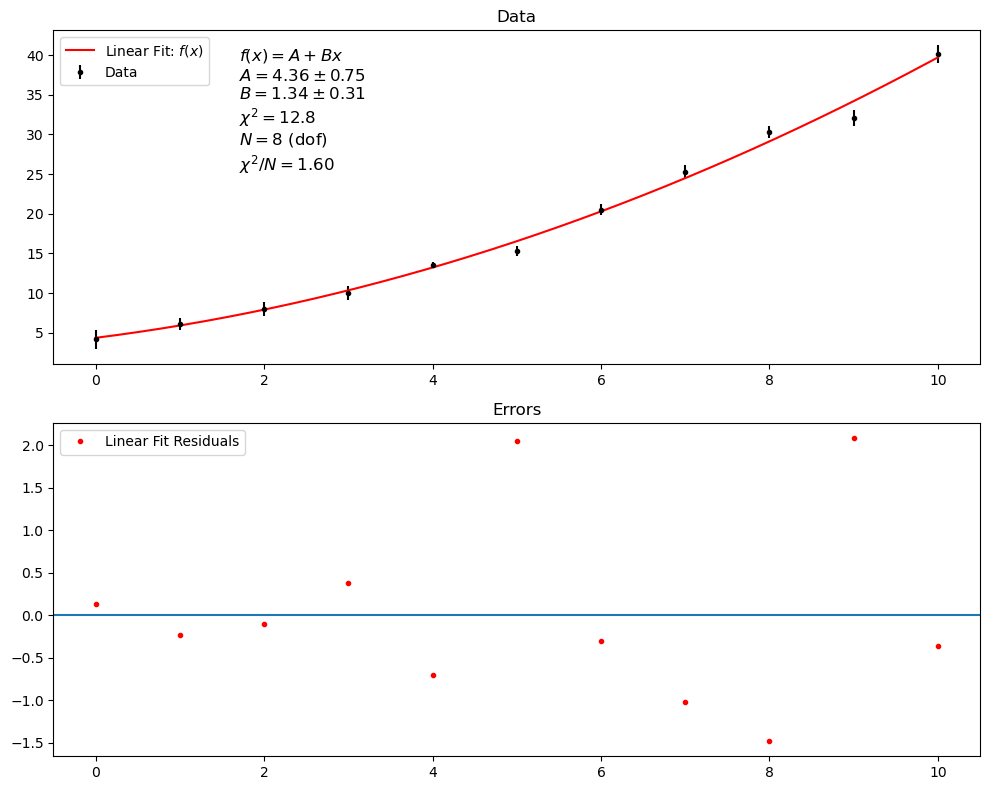

In [30]:
fig,(ax,ay) = plt.subplots(2, 1, figsize=(10, 8))
#the above is an equivalent way of doing the same thing

ax.errorbar(x, y, dy, fmt='k.', label = 'Data')
    # A basic scatter plot of some data in red
X = np.linspace(x.min(), x.max(), 500)
ax.plot(X, quadratic(my_pf, X), 'r-', label = 'Linear Fit: $f(x)$')

# Here is the text we want to include...
textfit = '$f(x) = A + Bx$ \n' 
textfit += '$A = {:.2f} \\pm {:.2f}$ \n'.format(my_pf[0], my_pferr[0]) 
textfit +='$B = {:.2f} \\pm {:.2f}$ \n'.format(my_pf[1], my_pferr[1]) 
textfit += '$\\chi^2= {:.1f}$ \n'.format(my_chisq) 
textfit += '$N = {}$ (dof) \n'.format(my_dof) 
textfit += '$\\chi^2/N = {:.2f}$'.format(my_chisq/my_dof) 

#... and below is where we actually place it on the plot
ax.text(0.2, 0.95, textfit, transform=ax.transAxes , fontsize=12,verticalalignment='top')

ay.plot(x,residual(my_pf, quadratic, x, y, dy),'r.',label='Linear Fit Residuals')
    # A plot of just the magnitudes of the errors
ax.legend()
ay.legend()
ay.axhline(0)
ax.set_title("Data")
ay.set_title("Errors")
fig.tight_layout()

plt.savefig('task5.pdf')

# Glossary of functions

## Python functions
  * `def newfunction(a, b)` : `def`ines a new function that takes two variables as input, named `a` and `b`.
    * `return a**2 + b**2` : at the end of a function, returns values defined by the following variable or calculation.
  * `sum(variable)` : calculates the sum of the values in a given variable.  `variable` needs to be a list or array.
  * `"You owe me {} dollars".format(debt)` : replaces the text in curly brackets with the variable `debt`.  
    * See the [python formatting examples](https://docs.python.org/3/library/string.html#format-examples) for more examples.
    * `"You owe me {:.2f} dollars".format(debt)` : replaces the curly brackets with the value of debt, as a two decimal floating-point number.
  * `try` : defines a block of code that you want to monitor for errors.  Nothing special happens if everything works.
    * `except` : a partner to `try`, runs if there were any errors brought up in a `try` block of code.  In our case, we use it to force the fit function to give *something* back even if it fails, so that the whole notebook doesn't come to a grinding halt.
  * `for item in values`: Creates a loop over every element in the list `values`.  This runs the code in the indented section once for every element in values, where the current element is referred to as `item`.
    * If you're used C, you'd have a similar statement as `for (i=0;i<n;i++)`.  Python lets you skip over the fiddly bits like indexing arrays and get straight to work.
  * `a += b` : adds the value of variable `b` to `a`.  If these are strings, it tacks `b` onto the end of `a`.
  * `print("\\")` : printe out a backslash `\` character
    * See the documentation on [escape sequences](https://docs.python.org/3/reference/lexical_analysis.html#escape-sequences) for further details.

  
## Numpy functions

  * `np.loadtxt("filename")` : loads values from a file named "filename".  Note that the file *must* be in the same directory as your python notebook.
    * `np.loadtxt("filename",delimiter=",")` : loads values from a file named "filename", using commas to separate values in rows.
  * `.T` : returns the transpose of a numpy array.
  * `.dot()` : returns the dot product of the array before the command and the array in paranthesis.
  * `np.linalg.inv` : finds the inverse of an array.
  * `np.diagonal` : returns the diagonal elements of a multidimensional array.
  * `np.sqrt` : returns the square root of a value.  Works on individual numbers or elements of an array.
  * `np.nan` : a value that Python recognizes as `n`ot `a` `n`umber.  You can save it as a value, but trying to do math with it will give another nan result.
    * Why would we do this?  Because sometimes we want a program to keep going even if a calculation results in gibberish.  

  
## Matplotlib functions

  * `ax.hline(5)` : creates a horizontal line at y = 5  .
  
## Scipy functions
  * `from scipy import optimize` : loads the scipy library for optimization functions.
    *  `optimize.least_squares(residual, p0, args=(func,xvar, yvar, err))` : Uses an algorithm for [least squares optimization](https://en.wikipedia.org/wiki/Least_squares) to minimize the `residual` function.  p0 is a list of parameters(constants) the function uses, and `args` is a list of variables used by the function.  In our case, the residual is the difference between the function we're fitting and the data we have, weighted by our uncertainty values.